# Titanic Data - Effect of Single and Double Feature Training by Correlation on Model Accuracy with no Hyperparameter Tuning

In this notebook, we will explore the effect that correlations have on our ability to predict correct target variables. The idea for this came from my first attempt at creating a model to accurately predict the survival of passengers on the Titanic. In that attempt, I created a rather simplistic model that incorporated only a few features when creating and training the model. I wanted to see what would happen if I created a model based on a single feature and how accurate this model would be. To do this, we will see which features correlate strongest with the target variable and then create and train separate models on the three strongest correlating features. From here, we will then create models based on combinations of these three strongest features and observe what effect this has on model accuracy.

## Project Overview
Let's lay out a game plan for how we will complete the above:

### 1. Understand what we're doing:
1. Where are we getting the data?
2. What are we trying to predict?
3. What sort of model do we need for this problem? Where will we get this model?

### 2. Import tools and data
Import all the necessary libraries we will need. Load the data into our project

### 3. Explore the data
1. What does the data look like? What features are there? What is the target variable?
2. Are there any missing values? How will we deal with those?
3. Are there any non-numeric features? How will we deal with those?
4. Do any columns need to be dropped?
5. Which features appear to correlate strongly with our target variable?

### 4. Clean up the data and split into training and validation sets
1. Based on step 3, what data transformations do we need to perform? How will we perform those?
2. After all necessary transformations, split the data into training and validation sets (test set is in separate file)

### 5. Modeling and Evaluation
Create and train the model. Make predictions based on the validation set and evaluate accuracy. Use visualization tools to communicate predictions and scoring.

### 6. Tune the model
Since we are only interested in the baseline model performance, we will not be tuning our models in this project (this may be a good idea for a future project).

### 7. Use the model
Import the test set and make predictions using our best model. Export predictions.

### 8. Reflection
What did we learn from this project?

## 1. Understand what we're doing
For this project, we will attempt to predict the survival of the Titanic passengers using baseline models (no parameter tuning) that are trained and tested on only one or two strongly correlating features. The training, validation, and test data will come from Kaggle's Titanic competition page. Since this is a binary classification problem, we will use classification models to train on and make our predictions. The models we will use will be the RandomForest, KNearestNeighbors, and Logistic Regression models from Scikit-learn.

## 2. Import tools and data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

In [53]:
df = pd.read_csv("titanic-data/train.csv")
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## 3. Explore the data

In [54]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [55]:
df.shape

(891, 12)

In [56]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


PassengerId, Name, and Ticket number most likely have no correlation to a passenger's survival so we will be dropping those. The actual cabin number itself also likely has little correlation; although, I see that the cabins listed have a C at the front. I wonder if this indicates cabin class?

Next, let's see what data types we have and if there are any missing values

In [57]:
df.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [58]:
df.dtypes == 'object'

PassengerId    False
Survived       False
Pclass         False
Name            True
Sex             True
Age            False
SibSp          False
Parch          False
Ticket          True
Fare           False
Cabin           True
Embarked        True
dtype: bool

The feature columns Name and Ticket are being dropped so we don't care about those. We can transform Sex and Embarked into dummy variables.

In [59]:
df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Since Cabin has so many missing values, we may end up just dropping it. For age, we will fill missing values with the median age.

## 4. Clean up the data and split into training and validation sets

To summarize the transformations we need to perform from section 3:
1. Drop PassengerId, Name, Ticket, and Cabin
2. Transform Sex and Embarked into dummy variables
3. Fill missing values in Age column with the median

In [60]:
df.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin'], inplace=True)
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


In [61]:
df = pd.get_dummies(df, columns=['Sex', 'Embarked'], drop_first=True)
df.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S
0,0,3,22.0,1,0,7.2500,1,0,1
1,1,1,38.0,1,0,71.2833,0,0,0
2,1,3,26.0,0,0,7.9250,0,0,1
3,1,1,35.0,1,0,53.1000,0,0,1
4,0,3,35.0,0,0,8.0500,1,0,1


In [62]:
df.Age.fillna(df.Age.median(), inplace=True)

In [63]:
df.isna().sum()

Survived      0
Pclass        0
Age           0
SibSp         0
Parch         0
Fare          0
Sex_male      0
Embarked_Q    0
Embarked_S    0
dtype: int64

Now that we have transformed our data, let's save the dataframe into a csv. Afterwards, we will create a correlation matrix to see which features correlate strongest. Based on this, we will drop all but that feature to use in training and evaluating. Saving this csv now will allow us to use it later to train on different features.

In [64]:
df.to_csv("temp_df.csv")

Now, let's create a correlation matrix to see the strongest correlators

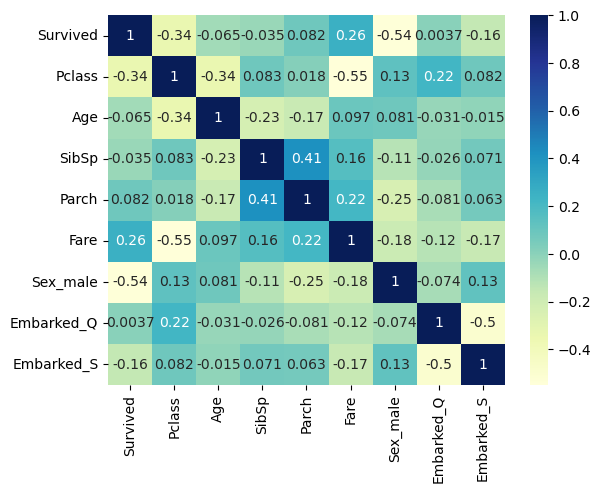

In [65]:
sns.heatmap(df.corr(),
           annot=True,
           cmap='YlGnBu');

One thing to note about the above correlation matrix. When it comes to the Sex column, a negative correlation does not mean that it necessarily is a negative correlation. Remember, our values for Sex are 0 for female and 1 for male, so a strong "negative" correlation simply means that it sucked to be a dude on the Titanic when it came to your survival chances. Similarly, a negative correlation for class implies that a lower class correlated more strongly with survival. This makes sense; the lowest class number was "first class" and these passengers apparently had a better chance at survival. 

**Taking into account the above, let's take Sex, Pclass, and Fare to be our strongest correlating features (in that order)**

Let's drop all columns in our dataframe except for Sex and Survival. This is what we will use in the first iteration of our model

In [66]:
df.columns

Index(['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Sex_male',
       'Embarked_Q', 'Embarked_S'],
      dtype='object')

In [67]:
df = df[['Survived', 'Sex_male']]
df.head()

,Survived,Sex_male
0,0,1
1,1,0
2,1,0
3,1,0
4,0,1


In [82]:
# When fitting the models, we got an error when we only have one feature column. Here, we duplicate our feature column to allow for fitting
df['Sex_male_2'] = df['Sex_male']
df.head()

,Survived,Sex_male,Sex_male_2
0,0,1,1
1,1,0,0
2,1,0,0
3,1,0,0
4,0,1,1


Now that we have our dataframe, let's split into training and validation sets

In [77]:
y = df['Survived']
X = df[['Sex_male', 'Sex_male_2']]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=610)

In [79]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((712, 2), (179, 2), (712,), (179,))

## 5. Modeling and Evaluation

Now that we have our dataframe, let's create a function that will take a model and our X and y sets and return a score

In [80]:
def fit_and_score(model, X_train, X_val, y_train, y_val):
    model.fit(X_train, y_train)
    return model.score(X_val, y_val)

In [81]:
models = {'Random Forest': RandomForestClassifier(),
          'K Nearest Neighbors': KNeighborsClassifier(),
          'Logistic Regression': LogisticRegression()}

for name, model in models.items():
    print(name, fit_and_score(model, X_train, X_val, y_train, y_val))

Random Forest 0.8156424581005587
K Nearest Neighbors 0.5921787709497207
Logistic Regression 0.8156424581005587


Pretty good scoring. Now, let's reload our dataframe and fit and score our models on the PClass feature

In [83]:
df = pd.read_csv("temp_df.csv")
df.head()

,Unnamed: 0,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S
0,0,0,3,22.0,1,0,7.2500,1,0,1
1,1,1,1,38.0,1,0,71.2833,0,0,0
2,2,1,3,26.0,0,0,7.9250,0,0,1
3,3,1,1,35.0,1,0,53.1000,0,0,1
4,4,0,3,35.0,0,0,8.0500,1,0,1


In [84]:
df = df[['Survived', 'Pclass']]
df.head()

,Survived,Pclass
0,0,3
1,1,1
2,1,3
3,1,1
4,0,3


In [85]:
#Duplicate Pclass feature for modeling
df['Pclass_2'] = df['Pclass']
df.head()

,Survived,Pclass,Pclass_2
0,0,3,3
1,1,1,1
2,1,3,3
3,1,1,1
4,0,3,3


In [88]:
#Split data
y = df['Survived']
X = df[['Pclass', 'Pclass_2']]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=610)

In [89]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((712, 2), (712,), (179, 2), (179,))

In [90]:
#Fit and score
models = {'Random Forest': RandomForestClassifier(),
          'K Nearest Neighbors': KNeighborsClassifier(),
          'Logistic Regression': LogisticRegression()}

for name, model in models.items():
    print(name, fit_and_score(model, X_train, X_val, y_train, y_val))

Random Forest 0.6256983240223464
K Nearest Neighbors 0.6424581005586593
Logistic Regression 0.6256983240223464


Understandably, these models do not perform nearly as well since this feature is our second strongest correlator

Now, let's do the same process for our Fare feature

In [91]:
df = pd.read_csv("temp_df.csv")
df.head()

,Unnamed: 0,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S
0,0,0,3,22.0,1,0,7.2500,1,0,1
1,1,1,1,38.0,1,0,71.2833,0,0,0
2,2,1,3,26.0,0,0,7.9250,0,0,1
3,3,1,1,35.0,1,0,53.1000,0,0,1
4,4,0,3,35.0,0,0,8.0500,1,0,1


In [92]:
df = df[['Survived', 'Fare']]
df.head()

,Survived,Fare
0,0,7.2500
1,1,71.2833
2,1,7.9250
3,1,53.1000
4,0,8.0500


In [93]:
#Duplicate Fare
df['Fare_2'] = df['Fare']
df.head()

,Survived,Fare,Fare_2
0,0,7.2500,7.2500
1,1,71.2833,71.2833
2,1,7.9250,7.9250
3,1,53.1000,53.1000
4,0,8.0500,8.0500


In [95]:
#Split data
y = df['Survived']
X = df[['Fare', 'Fare_2']]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=610)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((712, 2), (179, 2), (712,), (179,))

In [96]:
#Fit and score
models = {'Random Forest': RandomForestClassifier(),
          'K Nearest Neighbors': KNeighborsClassifier(),
          'Logistic Regression': LogisticRegression()}

for name, model in models.items():
    print(name, fit_and_score(model, X_train, X_val, y_train, y_val))

Random Forest 0.6703910614525139
K Nearest Neighbors 0.6536312849162011
Logistic Regression 0.6256983240223464


It is interesting that these models did slightly better than when we used the Pclass feature to fit and score our models

**Now, let's fit and score our models on the following combinations of features:**
1. Sex and Pclass
2. Sex and Fare
3. Pclass and Fare

In [101]:
df = pd.read_csv("temp_df.csv")
df.head()

,Unnamed: 0,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S
0,0,0,3,22.0,1,0,7.2500,1,0,1
1,1,1,1,38.0,1,0,71.2833,0,0,0
2,2,1,3,26.0,0,0,7.9250,0,0,1
3,3,1,1,35.0,1,0,53.1000,0,0,1
4,4,0,3,35.0,0,0,8.0500,1,0,1


In [104]:
df = df[['Survived', 'Pclass', 'Sex_male']]
df.head()

,Survived,Pclass,Sex_male
0,0,3,1
1,1,1,0
2,1,3,0
3,1,1,0
4,0,3,1


In [105]:
#Split data
y = df['Survived']
X = df[['Pclass', 'Sex_male']]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=610)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((712, 2), (179, 2), (712,), (179,))

In [106]:
#Fit and score
models = {'Random Forest': RandomForestClassifier(),
          'K Nearest Neighbors': KNeighborsClassifier(),
          'Logistic Regression': LogisticRegression()}

for name, model in models.items():
    print(name, fit_and_score(model, X_train, X_val, y_train, y_val))

Random Forest 0.7541899441340782
K Nearest Neighbors 0.7262569832402235
Logistic Regression 0.8156424581005587


It's interesting to note that Random Forest scored more poorly than when we used only the Sex feature. Also, K Nearest Neighbors improved, while LogisticRegression stayed the same

**Sex and Fare**

In [108]:
df = pd.read_csv("temp_df.csv")
df.head()

,Unnamed: 0,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S
0,0,0,3,22.0,1,0,7.2500,1,0,1
1,1,1,1,38.0,1,0,71.2833,0,0,0
2,2,1,3,26.0,0,0,7.9250,0,0,1
3,3,1,1,35.0,1,0,53.1000,0,0,1
4,4,0,3,35.0,0,0,8.0500,1,0,1


In [109]:
df = df[['Survived', 'Fare', 'Sex_male']]
df.head()

,Survived,Fare,Sex_male
0,0,7.2500,1
1,1,71.2833,0
2,1,7.9250,0
3,1,53.1000,0
4,0,8.0500,1


In [110]:
y = df['Survived']
X = df[['Fare', 'Sex_male']]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=610)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((712, 2), (179, 2), (712,), (179,))

In [111]:
#Fit and score
models = {'Random Forest': RandomForestClassifier(),
          'K Nearest Neighbors': KNeighborsClassifier(),
          'Logistic Regression': LogisticRegression()}

for name, model in models.items():
    print(name, fit_and_score(model, X_train, X_val, y_train, y_val))

Random Forest 0.7653631284916201
K Nearest Neighbors 0.7653631284916201
Logistic Regression 0.8212290502793296


Improvements for Random Forest and KNeighbors; slight improvement for Logistic Regression

**Pclass and Fare**

In [113]:
df = pd.read_csv("temp_df.csv")
df.head()

,Unnamed: 0,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S
0,0,0,3,22.0,1,0,7.2500,1,0,1
1,1,1,1,38.0,1,0,71.2833,0,0,0
2,2,1,3,26.0,0,0,7.9250,0,0,1
3,3,1,1,35.0,1,0,53.1000,0,0,1
4,4,0,3,35.0,0,0,8.0500,1,0,1


In [114]:
df = df[['Survived', 'Pclass', 'Fare']]
df.head()

,Survived,Pclass,Fare
0,0,3,7.2500
1,1,1,71.2833
2,1,3,7.9250
3,1,1,53.1000
4,0,3,8.0500


In [115]:
y = df['Survived']
X = df[['Pclass', 'Fare']]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=610)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((712, 2), (179, 2), (712,), (179,))

In [116]:
#Fit and score
models = {'Random Forest': RandomForestClassifier(),
          'K Nearest Neighbors': KNeighborsClassifier(),
          'Logistic Regression': LogisticRegression()}

for name, model in models.items():
    print(name, fit_and_score(model, X_train, X_val, y_train, y_val))

Random Forest 0.6871508379888268
K Nearest Neighbors 0.659217877094972
Logistic Regression 0.6256983240223464


Based on this, Pclass and Fare are not good predictors on their own.

Now for the heck of it, let's do a final fit and score using all three features: Sex, Pclass, and Fare and see how it performs

**Sex, Pclass, and Fare**

In [117]:
df = pd.read_csv("temp_df.csv")
df.head()

,Unnamed: 0,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S
0,0,0,3,22.0,1,0,7.2500,1,0,1
1,1,1,1,38.0,1,0,71.2833,0,0,0
2,2,1,3,26.0,0,0,7.9250,0,0,1
3,3,1,1,35.0,1,0,53.1000,0,0,1
4,4,0,3,35.0,0,0,8.0500,1,0,1


In [118]:
df = df[['Survived', 'Pclass', 'Fare', 'Sex_male']]
df.head()

,Survived,Pclass,Fare,Sex_male
0,0,3,7.2500,1
1,1,1,71.2833,0
2,1,3,7.9250,0
3,1,1,53.1000,0
4,0,3,8.0500,1


In [119]:
y = df['Survived']
X = df.drop("Survived", axis=1)

X.head()

,Pclass,Fare,Sex_male
0,3,7.2500,1
1,1,71.2833,0
2,3,7.9250,0
3,1,53.1000,0
4,3,8.0500,1


In [120]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=610)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((712, 3), (179, 3), (712,), (179,))

In [121]:
#Fit and score
models = {'Random Forest': RandomForestClassifier(),
          'K Nearest Neighbors': KNeighborsClassifier(),
          'Logistic Regression': LogisticRegression()}

for name, model in models.items():
    print(name, fit_and_score(model, X_train, X_val, y_train, y_val))

Random Forest 0.8100558659217877
K Nearest Neighbors 0.8100558659217877
Logistic Regression 0.8156424581005587


It is interesting to note that there is not significant improvement in our models when using three features versus two. Also, our Logistic Regression model performed slightly worse than when using only Sex and Fare features

Let's create a final Logistic Regression model based on Sex and Fare; we will use this model to create predictions from the test set

In [122]:
df = pd.read_csv("temp_df.csv")
df.head()

,Unnamed: 0,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S
0,0,0,3,22.0,1,0,7.2500,1,0,1
1,1,1,1,38.0,1,0,71.2833,0,0,0
2,2,1,3,26.0,0,0,7.9250,0,0,1
3,3,1,1,35.0,1,0,53.1000,0,0,1
4,4,0,3,35.0,0,0,8.0500,1,0,1


In [123]:
df = df[['Survived', 'Sex_male', 'Fare']]
df.head()

,Survived,Sex_male,Fare
0,0,1,7.2500
1,1,0,71.2833
2,1,0,7.9250
3,1,0,53.1000
4,0,1,8.0500


In [124]:
y = df['Survived']
X = df[['Sex_male', 'Fare']]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=610)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((712, 2), (179, 2), (712,), (179,))

In [125]:
model = LogisticRegression()
model.fit(X_train, y_train)
model.score(X_val, y_val)

0.8212290502793296

## 6. Tune the model

As stated at the beginning, we will not be tuning our model for the time being.

## 7. Use the model

Let's import the test set, make predictions on it, and export it as a csv to be submitted to Kaggle

In [160]:
test = pd.read_csv("titanic-data/test.csv")
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


Since we trained our model on Sex_male and Fare, let's get rid of everything in the test set except for Sex (need to transform), and Fare

In [161]:
test = test[['PassengerId', 'Sex', 'Fare']]
test.head()

,PassengerId,Sex,Fare
0,892,male,7.8292
1,893,female,7.0000
2,894,male,9.6875
3,895,male,8.6625
4,896,female,12.2875


In [162]:
test = pd.get_dummies(test, columns=['Sex'], drop_first=True)
test.head()

,PassengerId,Fare,Sex_male
0,892,7.8292,1
1,893,7.0000,0
2,894,9.6875,1
3,895,8.6625,1
4,896,12.2875,0


In [163]:
test.shape

(418, 3)

In [164]:
test.isna().sum()

PassengerId    0
Fare           1
Sex_male       0
dtype: int64

In [165]:
#Let's fill the missing Fare value with the median
test.Fare = test.Fare.fillna(test.Fare.median())
test.shape

(418, 3)

Now, let's make predictions using our LogisticRegression model

In [166]:
y_preds = model.predict(test[['Sex_male', 'Fare']])
y_preds[:5]

array([0, 1, 0, 0, 1], dtype=int64)

In [167]:
predictions = pd.DataFrame(data = {'PassengerId': test['PassengerId'],
                                   'Survived': y_preds})
predictions.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [168]:
predictions.shape

(418, 2)

In [170]:
#Export to CSV
predictions.to_csv("titanic-survivors-preds.csv", index=False)

## 8. Reflection

The final submission ended up performing slightly poorer than my first submission for the Titanic project; this project scored ~0.75 while my first submission scored ~0.77. All in all, this was an interesting experiment to see how training a model on only a few of the stronger correlating features of a dataset impacted model accuracy. Moving forward, it would be interesting to try adding more features to see if there emerges a zone where accuracy is optimized while number of features is minimized; an "equilibrium" zone, if you will.